In [ ]:
!pip install gymnasium

In [28]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

# Let's start by creating the environment.

env = gym.make("FrozenLake-v1", is_slippery=True)



In [29]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

observation, info, env.action_space

(0, {'prob': 1}, Discrete(4))

In [30]:
class QLAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs,
        action: int,
        reward: float,
        terminated: bool,
        next_obs,
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        
        self.q_values[obs][action] = self.q_values[obs][action] + self.lr * temporal_difference
    
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [31]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 4)  # reduce the exploration over time
final_epsilon = 0.001

agent = QLAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [32]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [02:04<00:00, 802.99it/s]


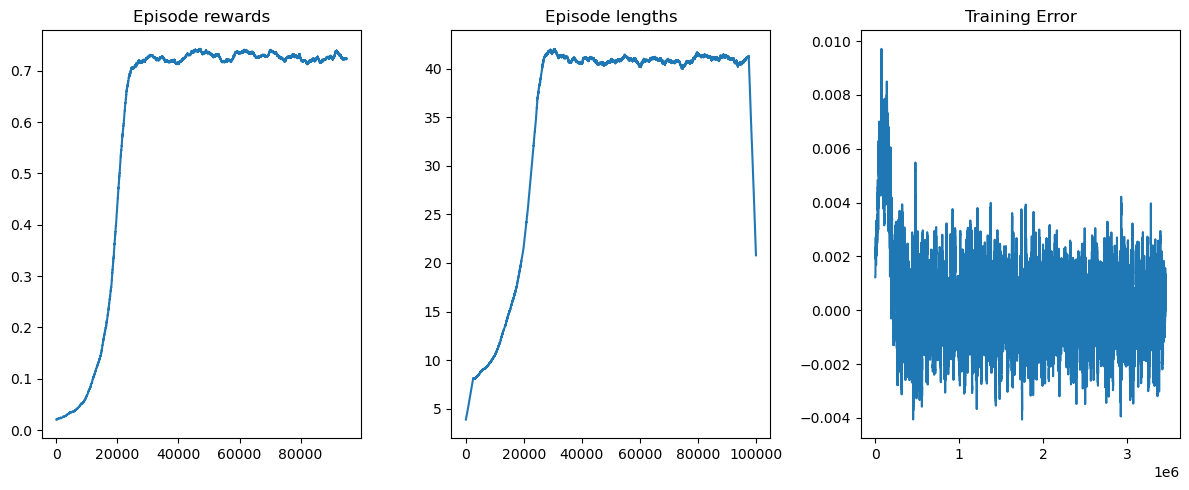

In [33]:
rolling_length = 5000
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [34]:
agent.q_values

defaultdict(<function __main__.QLAgent.__init__.<locals>.<lambda>()>,
            {0: array([0.173541  , 0.16558927, 0.1658032 , 0.16348333]),
             1: array([0.11044568, 0.10886994, 0.09712782, 0.15302445]),
             5: array([0., 0., 0., 0.]),
             2: array([0.1555158 , 0.13102688, 0.12907978, 0.12548649]),
             3: array([0.05481975, 0.05314221, 0.04142603, 0.12243471]),
             7: array([0., 0., 0., 0.]),
             4: array([0.20512204, 0.16138036, 0.14897461, 0.11803037]),
             8: array([0.14934352, 0.21322135, 0.1817242 , 0.27382278]),
             12: array([0., 0., 0., 0.]),
             6: array([0.18774264, 0.11062028, 0.13532712, 0.04291534]),
             9: array([0.24793224, 0.38613948, 0.27670051, 0.21472545]),
             10: array([0.42821611, 0.33152127, 0.26874106, 0.18344482]),
             11: array([0., 0., 0., 0.]),
             14: array([0.53868243, 0.7225733 , 0.64910209, 0.59829547]),
             13: array([0.284094

In [25]:
0.73509189/0.7737809

0.9500000452324424

In [27]:
0.95**5

0.7737809374999998